# PHASE 2 GROUP 7 PROJECT

## Business Understanding

### Overview
The film industry is a dynamic global market , encompassing all stages of movie creation and distribution, with a powerful cultural and economic influence. As more companies enter the realm of original content, understanding which films resonate most with audiences becomes essential. Analyzing box office trends helps newcomers identify popular genres, profitable themes, and audience preferences, informing smart production choices. This data-driven approach equips new studios to craft engaging content, align with viewer interests, and improve their chances of making a lasting impact in a competitive landscape.

## Business Problem

ABC company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create

## Objectives

1. Identify Popular Film Genres by popularity

2. Identify Emerging Trends and Audience Preferences

3. Identify which type of film are profitable

4. Identify months with highest profit

## Data Understanding

After carefully analysising the data provided in relation to the business problem and the business understanding question. we have selected the following datasets :

1. im.db.zip
2. tn.movie_budgets.csv.gz
3. bom.movie_gross.csv.gz
4. tmdb.movies.csv.gz

In [1530]:
# import the packages
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from collections import defaultdict
from scipy.stats import linregress
import pickle

#### LOADING THE DATA

In [1531]:
bom = pd.read_csv('bom.movie_gross.csv.gz')
tnmovie = pd.read_csv('tn.movie_budgets.csv.gz')
tmdb = pd.read_csv('tmdb.movies.csv.gz')

con = sqlite3.connect("im.db")
imdb = pd.read_sql("""
SELECT *
FROM sqlite_master
"""
, con)


#### Exploring the data

##### > bom('bom.movie_gross.csv.gz')

In [1532]:
# checking the first two columns
bom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [1533]:
# display information about the data
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


##### > tnmovie('tn.movie_budgets.csv.gz')

In [1534]:
# checking the first two columns
tnmovie.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [1535]:
# display information about the data
tnmovie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


##### > tmdb(tmdb.movies.csv.gz)

In [1536]:
# checking the first two rows
tmdb.head(2)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [1537]:
# display information about the data
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


##### > imdb

In [1538]:
# checking the first two rows
imdb = pd.read_sql("""
SELECT *
FROM sqlite_master
"""
, con)
imdb.head(2)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."


In [1539]:
# display information about the data
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      8 non-null      object
 1   name      8 non-null      object
 2   tbl_name  8 non-null      object
 3   rootpage  8 non-null      int64 
 4   sql       8 non-null      object
dtypes: int64(1), object(4)
memory usage: 448.0+ bytes


### Data cleaning

#### # creation of cleaned_gross_budget.csv
we'll create a cleaned_gross_budget.csv by combining the 'bom.movie_gross.csv.gz' and 'tn.movie_budgets.csv.gz'

In [1540]:
# first we rename the column 'title' to 'movie'
bom2 = bom.rename(columns={'title': 'movie'})
# then we drop two columns, 'domestic_gross' and 'year'
bom3 = bom2.drop(['domestic_gross', 'year'], axis=1)
bom3.head(2)

,movie,studio,foreign_gross
0,Toy Story 3,BV,652000000
1,Alice in Wonderland (2010),BV,691300000


In [1541]:
# we drop a column, 'id'
tnmovie1 = tnmovie.drop(['id'], axis=1)
tnmovie1.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [1542]:
# we create a gross_budget dataframe by merging bom3 and tnmovie1
gross_budget= pd.merge(bom3, tnmovie1, on='movie', how='inner')
gross_budget.head(2)

,movie,studio,foreign_gross,release_date,production_budget,domestic_gross,worldwide_gross
0,Toy Story 3,BV,652000000,"Jun 18, 2010","$200,000,000","$415,004,880","$1,068,879,522"
1,Inception,WB,535700000,"Jul 16, 2010","$160,000,000","$292,576,195","$835,524,642"


In [1543]:
# we are removing dollar signs (\$) and commas (,), then converting the values to float type
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:

    gross_budget[col] = gross_budget[col].replace({'\\$': '', ',': ''}, regex=True).astype(float)
gross_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1247 non-null   object 
 1   studio             1246 non-null   object 
 2   foreign_gross      1086 non-null   object 
 3   release_date       1247 non-null   object 
 4   production_budget  1247 non-null   float64
 5   domestic_gross     1247 non-null   float64
 6   worldwide_gross    1247 non-null   float64
dtypes: float64(3), object(4)
memory usage: 77.9+ KB


In [1544]:
# Convert foreign gross, production_budget, domestic_gross, worldwide_gross from string to numeric
gross_budget['foreign_gross'] = pd.to_numeric(gross_budget['foreign_gross'], errors='coerce') 
gross_budget['production_budget'] = pd.to_numeric(gross_budget['production_budget'], errors='coerce')
gross_budget['domestic_gross'] = pd.to_numeric(gross_budget['domestic_gross'], errors='coerce')
gross_budget['worldwide_gross'] = pd.to_numeric(gross_budget['worldwide_gross'], errors='coerce')
gross_budget.head(2)

,movie,studio,foreign_gross,release_date,production_budget,domestic_gross,worldwide_gross
0,Toy Story 3,BV,652000000.0,"Jun 18, 2010",200000000.0,415004880.0,1.068880e+09
1,Inception,WB,535700000.0,"Jul 16, 2010",160000000.0,292576195.0,8.355246e+08


In [1545]:
gross_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1247 non-null   object 
 1   studio             1246 non-null   object 
 2   foreign_gross      1082 non-null   float64
 3   release_date       1247 non-null   object 
 4   production_budget  1247 non-null   float64
 5   domestic_gross     1247 non-null   float64
 6   worldwide_gross    1247 non-null   float64
dtypes: float64(4), object(3)
memory usage: 77.9+ KB


In [1546]:
# checking for missing values
gross_budget.isna().sum()

movie                  0
studio                 1
foreign_gross        165
release_date           0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [1547]:
# drop missing values in every colum 
for column in gross_budget.columns:
    gross_budget = gross_budget.dropna(subset=[column])

gross_budget.isna().sum()

movie                0
studio               0
foreign_gross        0
release_date         0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [1548]:
# checking how many duplicate rows exist in our DataFrame
gross_budget.duplicated().sum()

0

In [1549]:
gross_budget['release_date'] = pd.to_datetime(gross_budget['release_date'])
gross_budget["release_date"] = gross_budget["release_date"].dt.month

In [1550]:
gross_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1081 non-null   object 
 1   studio             1081 non-null   object 
 2   foreign_gross      1081 non-null   float64
 3   release_date       1081 non-null   int64  
 4   production_budget  1081 non-null   float64
 5   domestic_gross     1081 non-null   float64
 6   worldwide_gross    1081 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 67.6+ KB


In [1551]:
# save the cleaned data
gross_budget.to_csv('cleaned_gross_budget.csv', index=False)

#### # creation of cleaned_merged_data.csv
we'll create a cleaned_merged_data.csv by combining the 'tmdb.movies.csv.gz' and ''im.db'

In [1552]:
# here we drop columns that we don't need from the tmdb data
tmdb_drop = tmdb.drop(['Unnamed: 0', 'genre_ids', 'title', 'id'], axis=1)
tmdb_drop.head(2)

,original_language,original_title,popularity,release_date,vote_average,vote_count
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,7.7,10788
1,en,How to Train Your Dragon,28.734,2010-03-26,7.7,7610


In [1553]:
# movie_basic is a table in the imdb database
movbasic = pd.read_sql("""
select *
from movie_basics
;""", con)
movbasic.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [1554]:
# movie_ratings is also a table in the imdb database
movrating = pd.read_sql("""
select *
from movie_ratings
;""", con)
movrating.head(2)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [1555]:
# here we merge the two tables 
movies = pd.read_sql("""
select original_title, runtime_minutes, genres, averagerating, numvotes
from movie_basics
join movie_ratings
on movie_basics.movie_id = movie_ratings.movie_id
;""", con)
movies.head(2)

,original_title,runtime_minutes,genres,averagerating,numvotes
0,Sunghursh,175.0,"Action,Crime,Drama",7.0,77
1,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43


In [1556]:
# now we merge the tmbd and movies data to create a merged_data 
merged_data = pd.merge(tmdb_drop, movies, on='original_title', how='inner')
merged_data.head(2)

,original_language,original_title,popularity,release_date,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,7.7,10788,146.0,"Adventure,Fantasy,Mystery",7.7,425530
1,en,How to Train Your Dragon,28.734,2010-03-26,7.7,7610,98.0,"Action,Adventure,Animation",8.1,611299


In [1557]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17891 entries, 0 to 17890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_language  17891 non-null  object 
 1   original_title     17891 non-null  object 
 2   popularity         17891 non-null  float64
 3   release_date       17891 non-null  object 
 4   vote_average       17891 non-null  float64
 5   vote_count         17891 non-null  int64  
 6   runtime_minutes    17394 non-null  float64
 7   genres             17831 non-null  object 
 8   averagerating      17891 non-null  float64
 9   numvotes           17891 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 1.5+ MB


In [1558]:
# checking for null values
merged_data.isna().sum()

original_language      0
original_title         0
popularity             0
release_date           0
vote_average           0
vote_count             0
runtime_minutes      497
genres                60
averagerating          0
numvotes               0
dtype: int64

In [1559]:
# drop missing values in every colum 
for column in merged_data.columns:
    merged_data = merged_data.dropna(subset=[column])

print(merged_data.isna().sum())

original_language    0
original_title       0
popularity           0
release_date         0
vote_average         0
vote_count           0
runtime_minutes      0
genres               0
averagerating        0
numvotes             0
dtype: int64


In [1560]:
# checking for duplicated rows
merged_data.duplicated().sum()

945

In [1561]:
# drop duplicated rows
merged_data = merged_data.drop_duplicates()
merged_data.duplicated().sum()

0

In [1562]:
merged_data['release_date'] = pd.to_datetime(merged_data['release_date'])
merged_data["release_date"] = merged_data["release_date"].dt.month

In [1563]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16402 entries, 0 to 17890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_language  16402 non-null  object 
 1   original_title     16402 non-null  object 
 2   popularity         16402 non-null  float64
 3   release_date       16402 non-null  int64  
 4   vote_average       16402 non-null  float64
 5   vote_count         16402 non-null  int64  
 6   runtime_minutes    16402 non-null  float64
 7   genres             16402 non-null  object 
 8   averagerating      16402 non-null  float64
 9   numvotes           16402 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 1.4+ MB


In [1564]:
# save the cleaned data
merged_data.to_csv('cleaned_merged_data.csv', index=False)

##### # merge the two cleaned dataframes for further cleaning

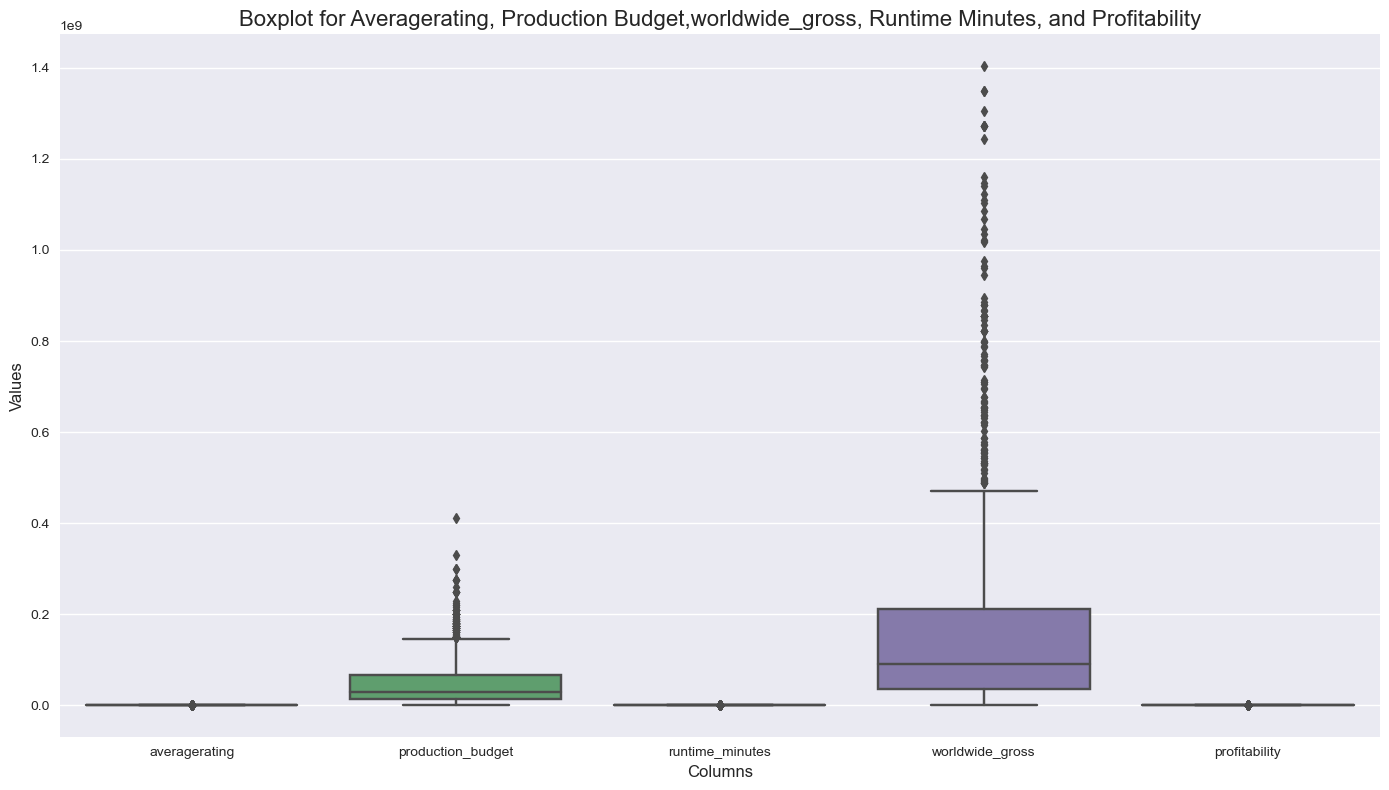

In [1565]:
# Import the data files
gross_budget_df = pd.read_csv('cleaned_gross_budget.csv')
merged_data_df = pd.read_csv('cleaned_merged_data.csv')

#drop the release_date column from the merged_data_df
merged_data_df = merged_data_df.drop(['release_date'], axis=1)

# Merge the datasets on 'movie' and 'original_title', with 'cleaned_merged_data.csv' as the main table
df = pd.merge(merged_data_df, gross_budget_df, left_on='original_title', right_on='movie', how='left')

# add a profitability column
df['profitability'] = (df['worldwide_gross'] - df['production_budget']) / df['production_budget']

# Split the genre column into three parts: genre, genre_class, and genre_class_grouping
df[['genre', 'genre_class', 'genre_class_grouping']] = df['genres'].str.split(',', n=2, expand=True)

# Checkicng for outliers
# Create a new DataFrame with the selected columns for the boxplot
columns_to_plot = ['averagerating', 'production_budget', 'runtime_minutes','worldwide_gross', 'profitability']

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the boxplot using Seaborn
sns.boxplot(data=df[columns_to_plot])

# Add title and labels
plt.title('Boxplot for Averagerating, Production Budget,worldwide_gross, Runtime Minutes, and Profitability', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

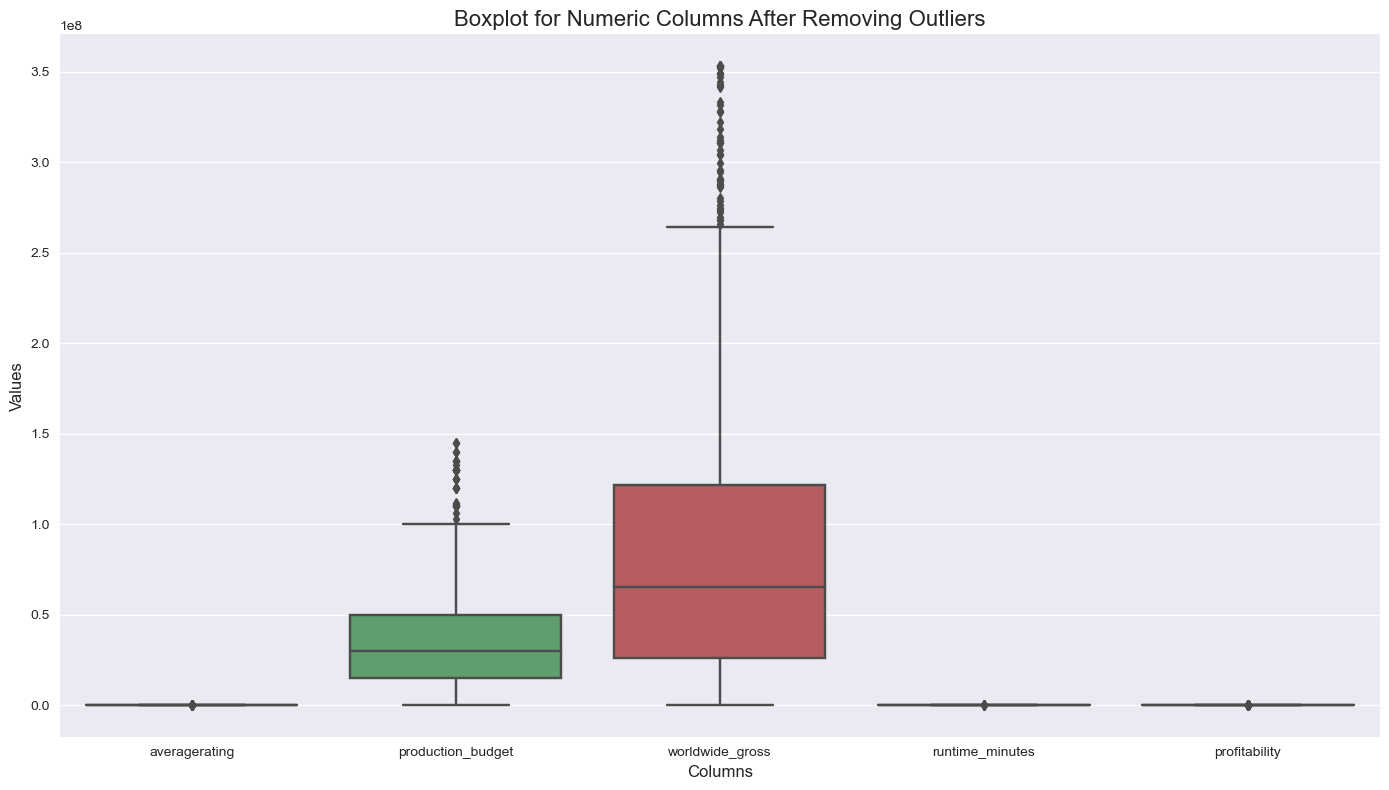

In [1566]:
# Use a function to remove outlier from multiple relevant columns using IQR method
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from specified columns
numeric_columns = ['averagerating', 'production_budget', 'worldwide_gross', 'runtime_minutes', 'profitability']
df_cleaned = remove_outliers(df, numeric_columns)

# Define the numeric columns you want to plot
numeric_columns = ['averagerating', 'production_budget', 'worldwide_gross', 'runtime_minutes', 'profitability']

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the boxplot using Seaborn
sns.boxplot(data=df_cleaned[numeric_columns])

# Add title and labels
plt.title('Boxplot for Numeric Columns After Removing Outliers', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [1567]:
df_cleaned.dropna()

,original_language,original_title,popularity,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,movie,studio,foreign_gross,release_date,production_budget,domestic_gross,worldwide_gross,profitability,genre,genre_class,genre_class_grouping
7,en,Megamind,22.855,6.8,3635,95.0,"Action,Animation,Comedy",7.3,207488,Megamind,P/DW,173500000.0,11.0,130000000.0,148415853.0,321887208.0,1.476055,Action,Animation,Comedy
12,en,The Expendables,21.517,6.1,4647,103.0,"Action,Adventure,Thriller",6.5,307897,The Expendables,LGF,171400000.0,8.0,82000000.0,103068524.0,268268174.0,2.271563,Action,Adventure,Thriller
14,en,Saw 3D,20.370,6.0,1488,90.0,"Crime,Horror,Mystery",5.6,83532,Saw 3D,LGF,90400000.0,10.0,17000000.0,45710178.0,133735284.0,6.866781,Crime,Horror,Mystery
16,en,The Book of Eli,18.985,6.7,3495,118.0,"Action,Adventure,Drama",6.9,271307,The Book of Eli,WB,62300000.0,1.0,80000000.0,94835059.0,158750817.0,0.984385,Action,Adventure,Drama
21,en,The A-Team,17.097,6.3,2703,117.0,"Action,Adventure,Thriller",6.8,235256,The A-Team,Fox,100000000.0,6.0,110000000.0,77222099.0,177241171.0,0.611283,Action,Adventure,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15143,en,A Wrinkle in Time,12.529,5.0,1073,109.0,"Adventure,Family,Fantasy",4.2,34888,A Wrinkle in Time,BV,32200000.0,3.0,103000000.0,100478608.0,133401882.0,0.295164,Adventure,Family,Fantasy
15162,en,"Paul, Apostle of Christ",12.005,7.1,98,108.0,"Adventure,Biography,Drama",6.7,5662,"Paul, Apostle of Christ",Affirm,5500000.0,3.0,5000000.0,17547999.0,25529498.0,4.105900,Adventure,Biography,Drama
15170,en,The 15:17 to Paris,11.576,5.3,799,94.0,"Biography,Drama,Thriller",5.2,21880,The 15:17 to Paris,WB,20800000.0,2.0,30000000.0,36276286.0,56096200.0,0.869873,Biography,Drama,Thriller
15264,en,Proud Mary,9.371,5.5,259,89.0,"Action,Crime,Drama",4.9,6805,Proud Mary,SGem,876000.0,1.0,30000000.0,20868638.0,21709539.0,-0.276349,Action,Crime,Drama


In [1568]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 7 to 15838
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   original_language     899 non-null    object 
 1   original_title        899 non-null    object 
 2   popularity            899 non-null    float64
 3   vote_average          899 non-null    float64
 4   vote_count            899 non-null    int64  
 5   runtime_minutes       899 non-null    float64
 6   genres                899 non-null    object 
 7   averagerating         899 non-null    float64
 8   numvotes              899 non-null    int64  
 9   movie                 899 non-null    object 
 10  studio                899 non-null    object 
 11  foreign_gross         899 non-null    float64
 12  release_date          899 non-null    float64
 13  production_budget     899 non-null    float64
 14  domestic_gross        899 non-null    float64
 15  worldwide_gross      

# DATA ANALYSIS

## EXPLORATORY DATA ANALYSIS(EDA)

#### Aggregate analysis
##### What are the top 10 movie genres by average rating?
##### What are the top 10 most profitable movie genres?
##### According to the release time, which months generate the highest profits?

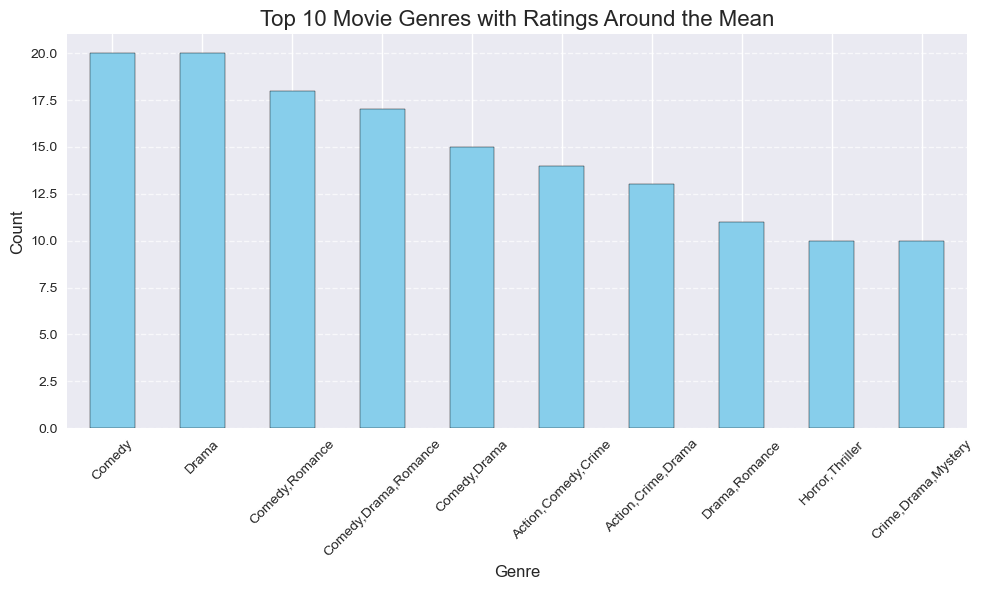

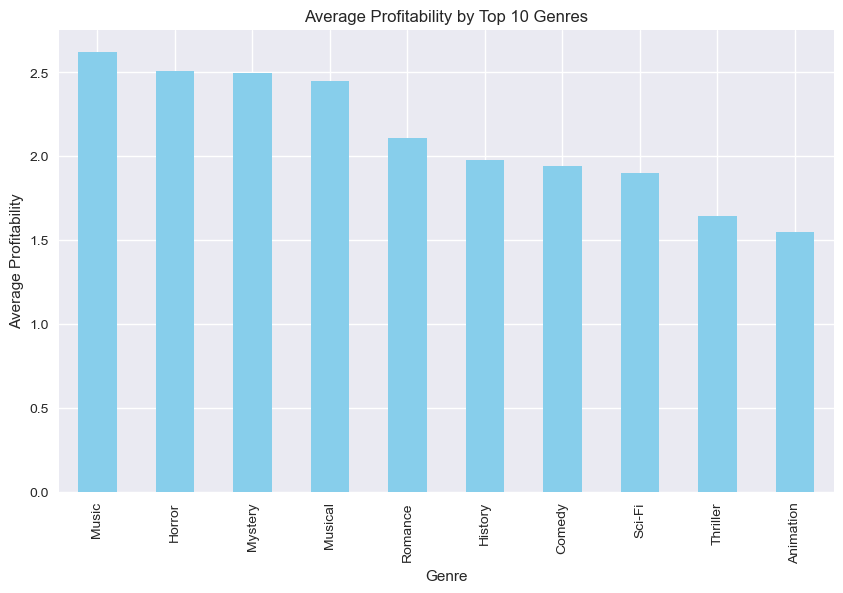

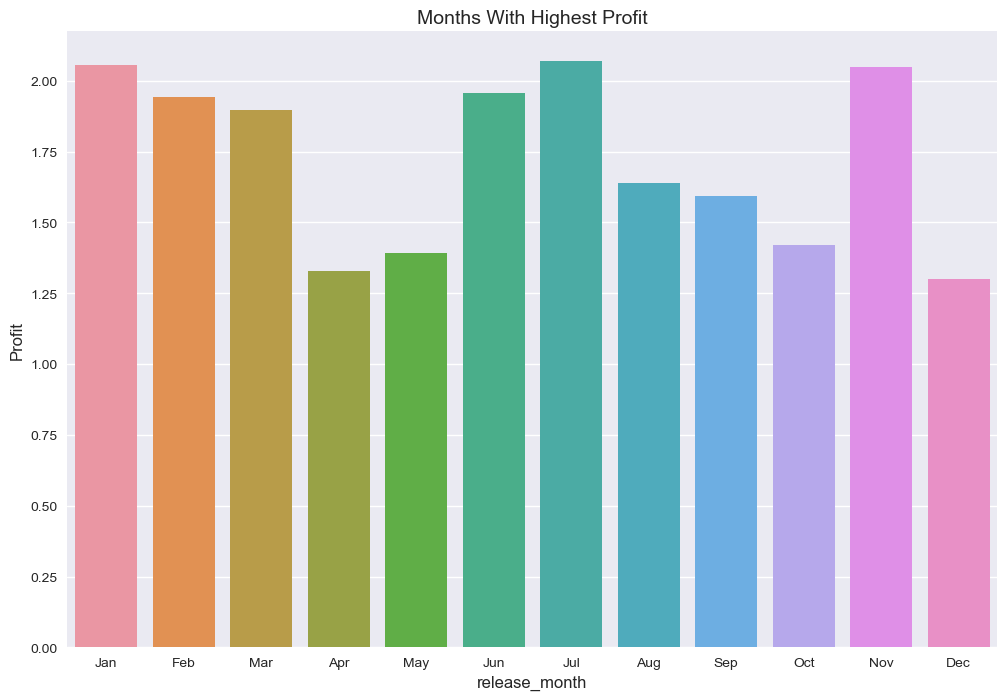

In [1569]:
# Calculate the mean average rating
mean_rating = df_cleaned['averagerating'].mean()

genre_counts = filtered_df['genres'].value_counts().head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Movie Genres with Ratings Around the Mean', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()# Split genres in each row and associate profitability with each genre
split_genres = []
profits = []

for index, row in df_cleaned.iterrows():
    genre_split = row["genres"].split(',')
    split_genres.extend(genre_split)
    profits.extend([row["profitability"]] * len(genre_split))

# Create a new DataFrame with split genres and profitability
split_genre_df = pd.DataFrame({
    'genre': split_genres,
    'profitability': profits,
    'production_budget': df_cleaned['production_budget'].repeat(df_cleaned['genres'].str.split(',').apply(len)).reset_index(drop=True)
})

# Plot for profitability by top 10 genres
top_genres = split_genre_df.groupby('genre')['profitability'].median().nlargest(10).index
avg_profitability = split_genre_df[split_genre_df['genre'].isin(top_genres)].groupby('genre')['profitability'].mean()
avg_profitability = avg_profitability.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_profitability.plot(kind='bar', color='skyblue')
plt.title('Average Profitability by Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Average Profitability')
plt.xticks(rotation=90)
plt.show()

# here we write a code that returns a Series with release_date as the index and the average profitability for each release date.
month_profit = df_cleaned.groupby('release_date')['profitability'].mean()
# covert month_profit into a DataFrame
monthly_profit_df = pd.DataFrame(month_profit)
monthly_profit_df.reset_index(drop=False, inplace=True)
# Assuming 'monthly_profit_df' is a DataFrame with 'release_date' and 'profitability' columns

fig, ax = plt.subplots(figsize=(12, 8))

# You can directly pass the DataFrame column names to sns.barplot using the 'x' and 'y' keyword arguments
sns.barplot(x='release_date', y='profitability', data=monthly_profit_df, ax=ax)

ax.set_title('Months With Highest Profit', fontsize=14)
ax.set_xlabel("release_month", fontsize=12)
ax.set_ylabel("Profit", fontsize=12)
ax.set_xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

fig.savefig('Months With Highest Profit.png')



#### - Most consistently rated genres are Drama and Comedy, the highest profitability is seen in Music and Horror genres, and releasing films in January, July, and November tends to maximize profits.

#### Descriptive statistics

In [1570]:
# List of columns to analyze
columns_to_analyze = ['averagerating', 'production_budget', 'worldwide_gross', 'runtime_minutes', 'profitability']

# Check if columns exist in the DataFrame
missing_columns = [col for col in columns_to_analyze if col not in df_cleaned.columns]
if missing_columns:
    print(f"The following columns are missing from the DataFrame: {missing_columns}")
else:
    # Select the relevant columns
    selected_data = df_cleaned[columns_to_analyze]

    # Perform descriptive statistics
    descriptive_stats = selected_data.describe()

    # Display the statistics
    print("Descriptive Statistics:")
    print(descriptive_stats)

Descriptive Statistics:
       averagerating  production_budget  worldwide_gross  runtime_minutes  \
count     899.000000       8.990000e+02     8.990000e+02       899.000000   
mean        6.313904       3.687570e+07     8.825520e+07       106.056730   
std         0.963057       3.013051e+07     8.189584e+07        15.322666   
min         2.100000       4.000000e+05     0.000000e+00        62.000000   
25%         5.800000       1.500000e+07     2.606169e+07        95.000000   
50%         6.400000       3.000000e+07     6.528273e+07       105.000000   
75%         7.000000       5.000000e+07     1.216812e+08       116.000000   
max         9.200000       1.450000e+08     3.528311e+08       148.000000   

       profitability  
count     899.000000  
mean        1.715422  
std         2.064894  
min        -1.000000  
25%         0.236622  
50%         1.242847  
75%         2.533632  
max         8.525090  


#### - The descriptive statistics reveal that the average movie has a moderate rating (mean rating of 6.36), with budgets and worldwide grosses varying widely (mean budgets around 38.6 million and gross around 90.9 million) and runtime averaging approximately 106 minutes. Profitability exhibits substantial variability, with a mean of 1.68 and a large standard deviation (2.82), indicating that while some movies are highly profitable, others experience losses, as shown by the negative minimum profitability value. The wide ranges and standard deviations across financial metrics suggest high variability in movie performance and budgets.

### Variable relationships
#### Is there a relationship between a movie's runtime and its user rating?
#### How does production budget impact a movie's box office revenue?

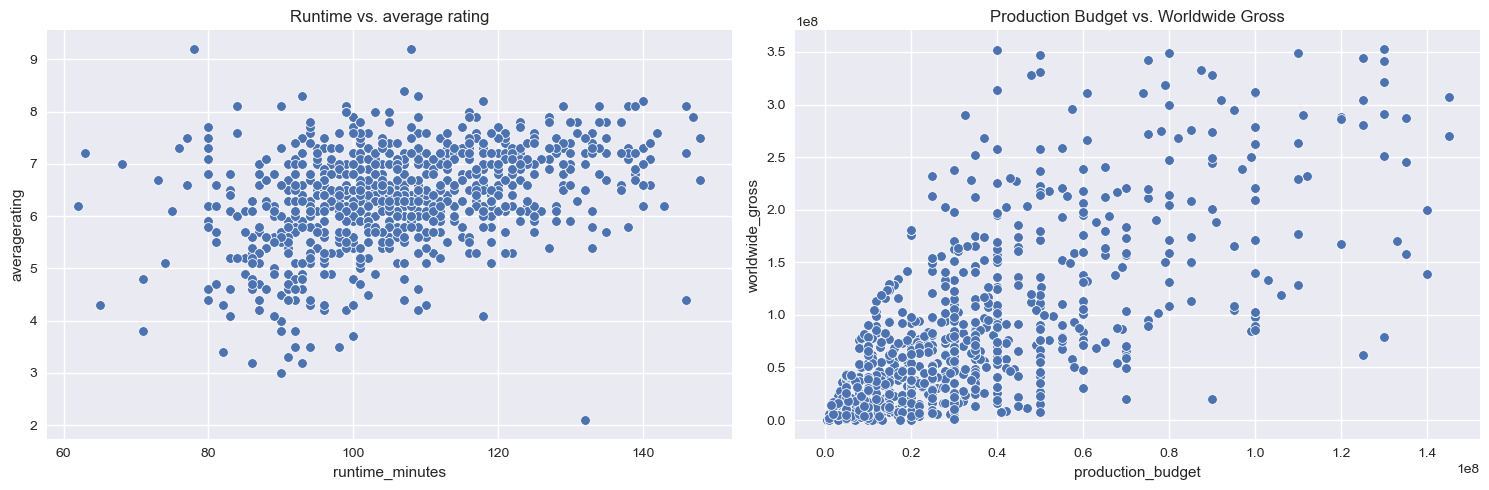

In [1571]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# runtime vs vote_average
sns.scatterplot(data=df_cleaned, x='runtime_minutes', y='averagerating', ax=axes[0])
axes[0].set_title('Runtime vs. average rating')

# production_budget vs worldwide_gross
sns.scatterplot(data=df_cleaned, x='production_budget', y='worldwide_gross', ax=axes[1])
axes[1].set_title('Production Budget vs. Worldwide Gross')

plt.tight_layout()
plt.show()

#### - The scatter plots show a weak positive relationship between runtime_minutes and averagerating, indicating that movie runtime has little effect on user ratings, while production_budget and worldwide_gross exhibit a more noticeable positive trend, suggesting that higher budgets tend to correspond with higher box office revenues.

## STATISTICAL DISTRIBUTION

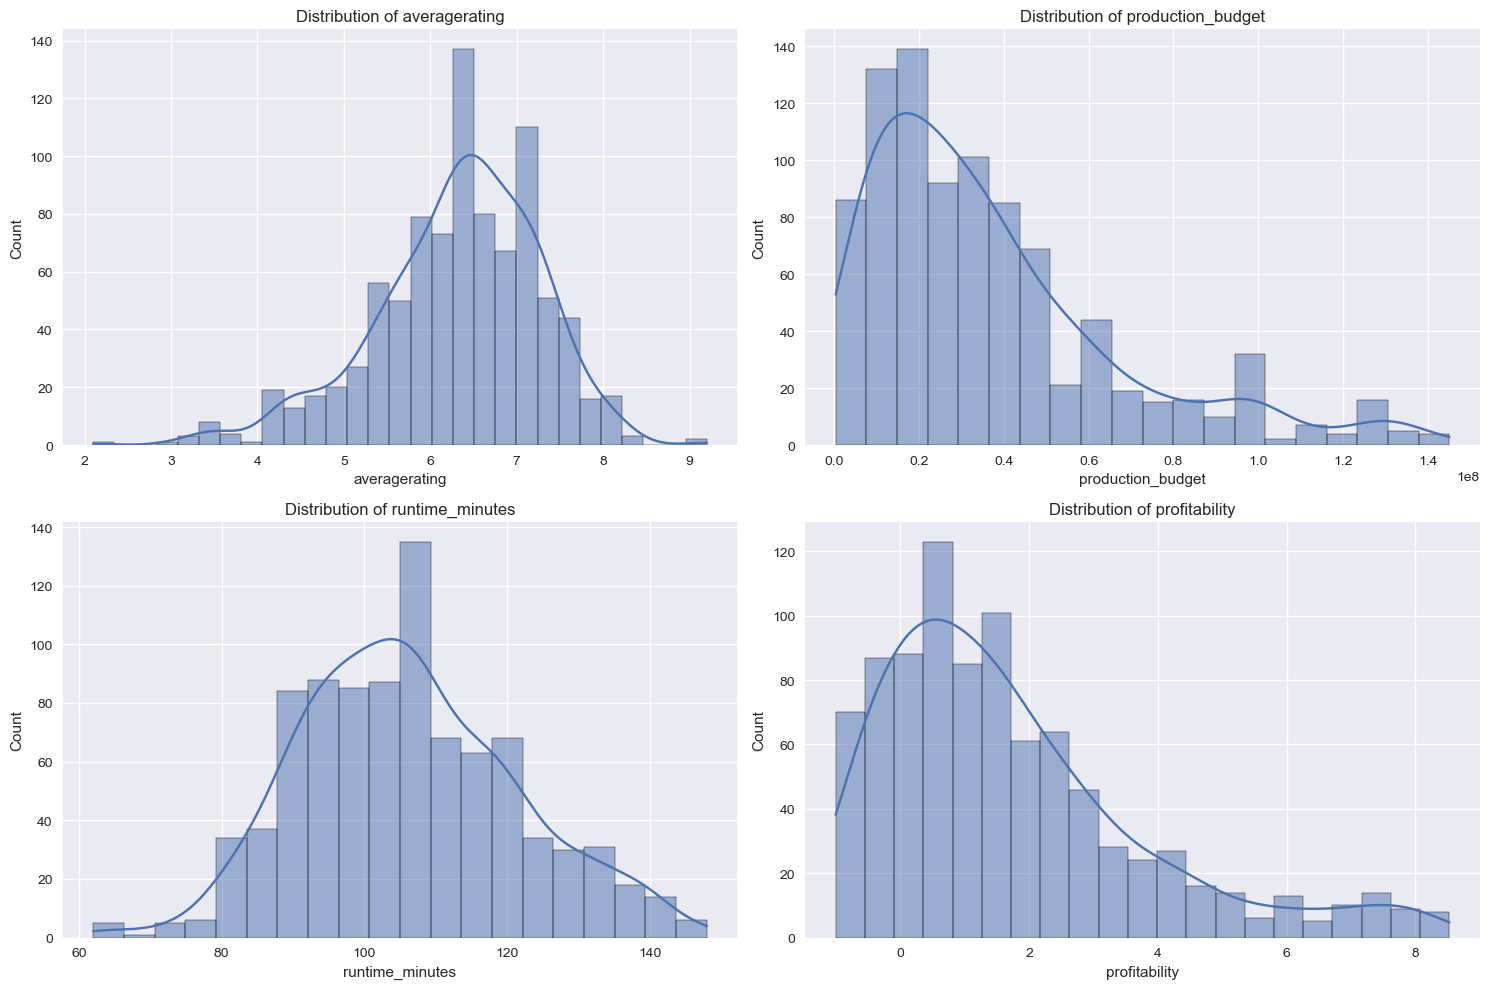

In [1572]:
# Plot distributions
columns_to_plot = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_cleaned[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

##### - The data appears to be visibly normally distributed for average rating, production budget, and profitability, while runtime minutes are skewed right, with most movies falling between 90 and 120 minutes.

### Normality Test
#### Perform normality test using the Jarque-Bera Test

>> Jarque-Bera test for averagerating: Statistic=87.54385989464758, p-value=0.0
averagerating is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

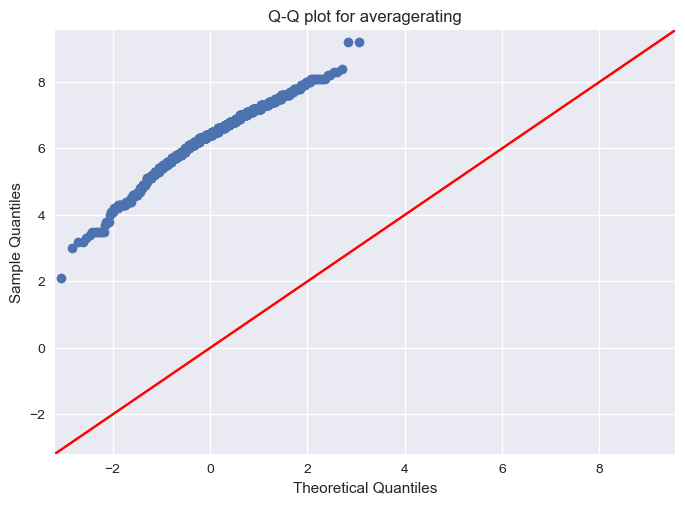

>> Jarque-Bera test for production_budget: Statistic=381.3401898550876, p-value=0.0
production_budget is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

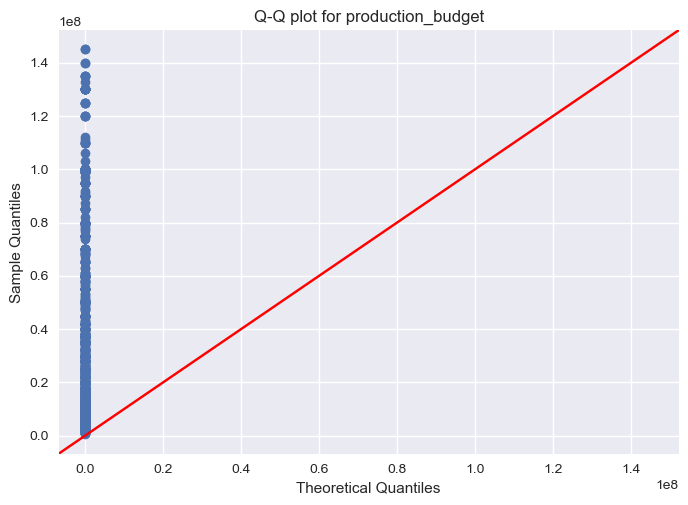

>> Jarque-Bera test for runtime_minutes: Statistic=11.527029141336298, p-value=0.0031400562328601778
runtime_minutes is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

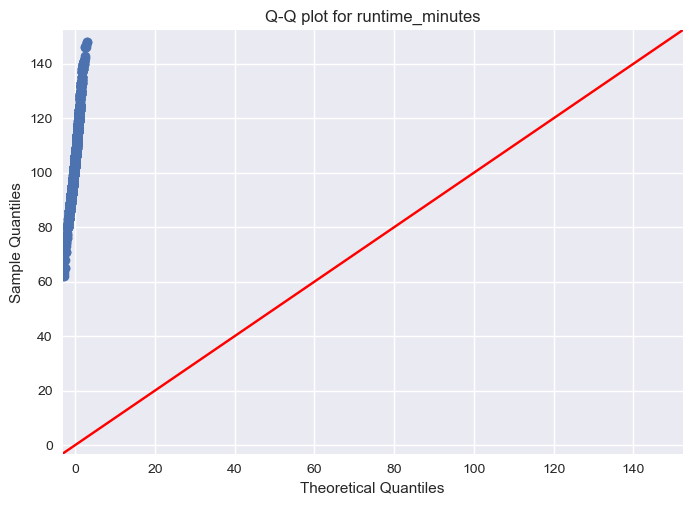

>> Jarque-Bera test for profitability: Statistic=291.5205379951693, p-value=0.0
profitability is likely not normally distributed (reject H0 at alpha=0.05).


<Figure size 600x600 with 0 Axes>

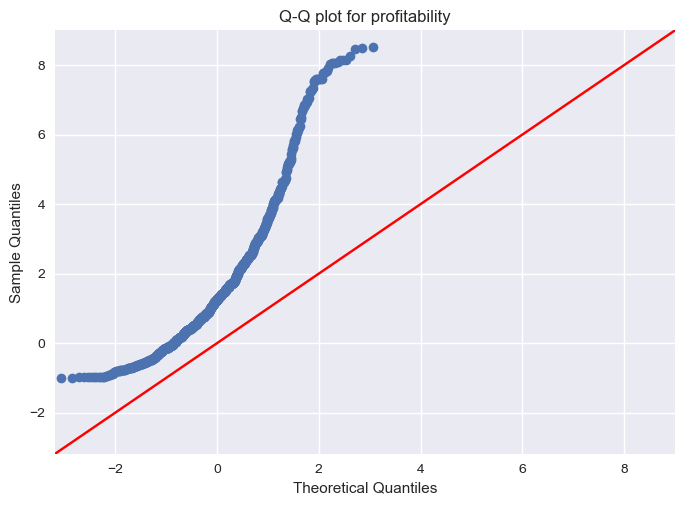

In [1573]:
# List of columns to test for normality
columns_to_test = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']

# Testing for normality using the Jarque-Bera test
for col in columns_to_test:
    # Drop NaN values for the column
    data = df_cleaned[col].dropna()
    
    # Jarque-Bera Test
    jarque_bera_stat, jarque_bera_p_value = stats.jarque_bera(data)
    print(f'>> Jarque-Bera test for {col}: Statistic={jarque_bera_stat}, p-value={jarque_bera_p_value}')
    
    # Interpretation
    if jarque_bera_p_value < 0.05:
        print(f"{col} is likely not normally distributed (reject H0 at alpha=0.05).")
    else:
        print(f"{col} is likely normally distributed (fail to reject H0 at alpha=0.05).")
    
    # Visual Check: Q-Q Plot
    plt.figure(figsize=(6,6))
    sm.qqplot(data, line ='45')  # 45-degree reference line
    plt.title(f'Q-Q plot for {col}')
    plt.show()

#### -The Jarque-Bera test results indicate that all the variables analyzed—averagerating, production_budget, runtime_minutes, and profitability—are not normally distributed

### Normalization
#### Use Log Transformations to normalize the columns

In [1574]:
# Assuming df_cleaned is your dataframe and columns to be normalized are mentioned
columns_to_transform = ['averagerating', 'production_budget', 'runtime_minutes', 'profitability']

# Define a function to apply Box-Cox (for positive values) or Yeo-Johnson (for mixed values)
def normalize_data(df, columns):
    normalized_data = pd.DataFrame()

    for col in columns:
        # Check if the column contains negative or zero values
        if (df[col] <= 0).any():
            # Use Yeo-Johnson transformation if there are non-positive values
            normalized_data[col], _ = stats.yeojohnson(df[col].dropna())
        else:
            # Use Box-Cox transformation for positive values
            normalized_data[col], _ = stats.boxcox(df[col].dropna())

    return normalized_data

# Apply the transformation
normalized_df = normalize_data(df_cleaned, columns_to_transform)

# Print out the first few rows of the transformed data
print(normalized_df.head())

   averagerating  production_budget  runtime_minutes  profitability
0      36.407069         473.222573        11.149541       1.028770
1      28.052604         419.837516        11.549872       1.399563
2      20.040012         278.674826        10.888052       2.769863
3      32.082816         417.151815        12.248977       0.753627
4      45.951850         417.151815        13.096168       1.589197


### Display distribution after normalization

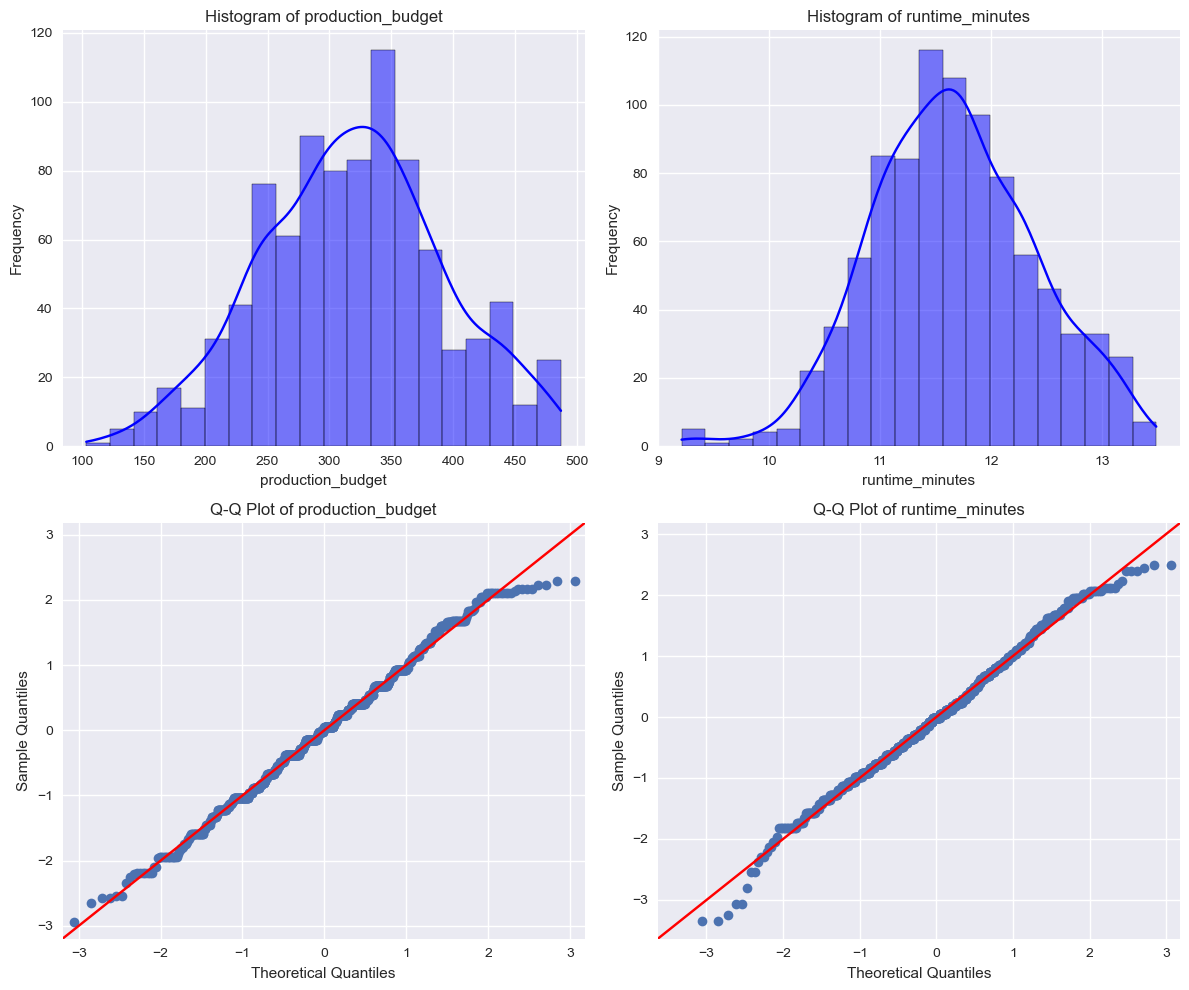

In [1575]:
# Display the distributions in the normally distributed columns
# Select the columns that are likely normally distributed
normal_columns = ['production_budget', 'runtime_minutes']

# Set up plot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# Plot histograms
for i, col in enumerate(normal_columns):
    # Histogram
    sns.histplot(normalized_df[col], bins=20, kde=True, color="blue", ax=axes[0, i])
    axes[0, i].set_title(f"Histogram of {col}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")

    # Q-Q Plot
    sm.graphics.qqplot(normalized_df[col], dist=stats.norm, line='45', fit=True, ax=axes[1, i])
    axes[1, i].set_title(f"Q-Q Plot of {col}")
    axes[1, i].set_xlabel("Theoretical Quantiles")
    axes[1, i].set_ylabel("Sample Quantiles")

# Adjust layout
fig.tight_layout()
plt.show()

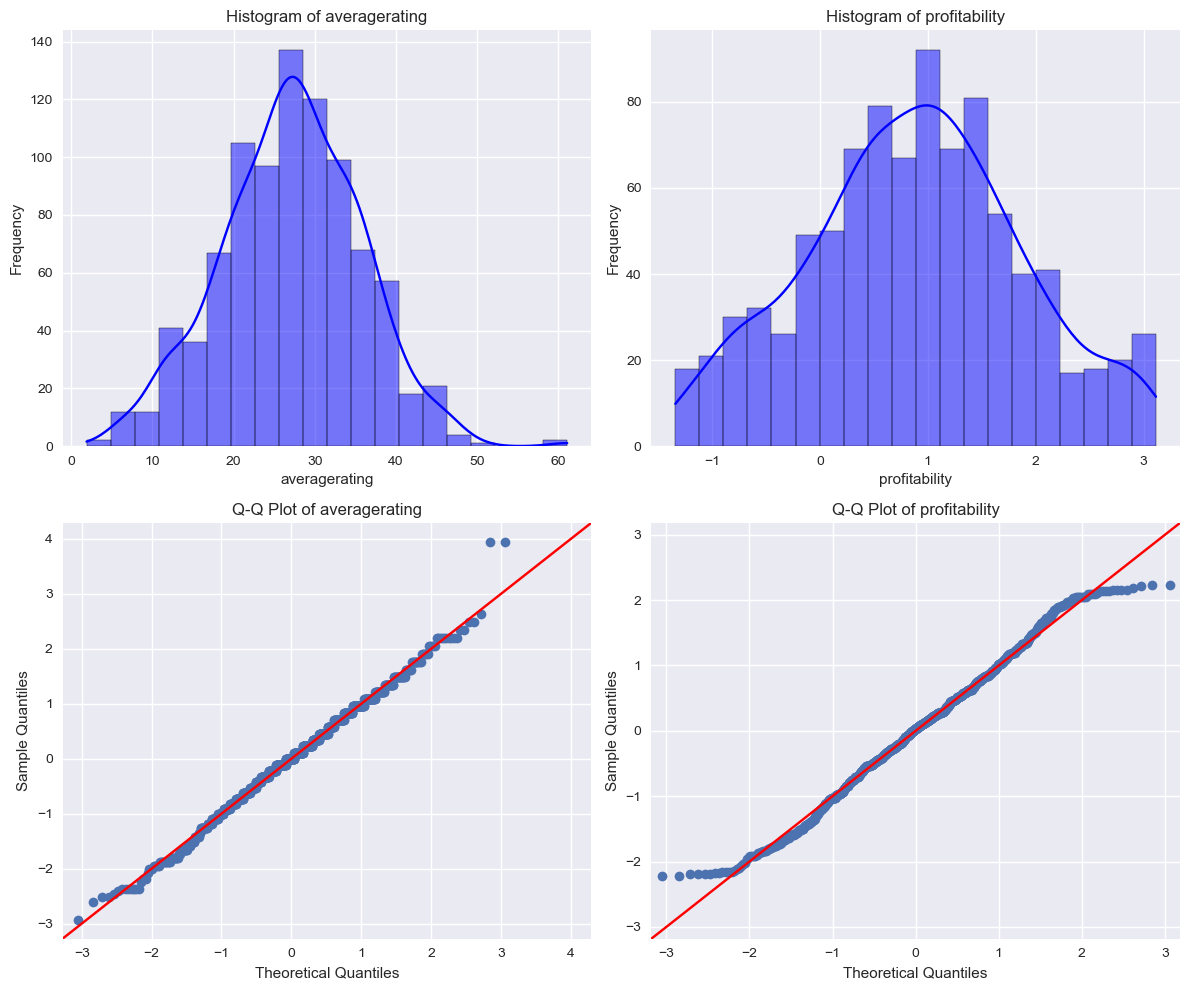

In [1576]:
# Display the distributions in the normally distributed columns
# Select the columns that are likely normally distributed
normal_columns = ['averagerating', 'profitability']

# Set up plot layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# Plot histograms
for i, col in enumerate(normal_columns):
    # Histogram
    sns.histplot(normalized_df[col], bins=20, kde=True, color="blue", ax=axes[0, i])
    axes[0, i].set_title(f"Histogram of {col}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")

    # Q-Q Plot
    sm.graphics.qqplot(normalized_df[col], dist=stats.norm, line='45', fit=True, ax=axes[1, i])
    axes[1, i].set_title(f"Q-Q Plot of {col}")
    axes[1, i].set_xlabel("Theoretical Quantiles")
    axes[1, i].set_ylabel("Sample Quantiles")

# Adjust layout
fig.tight_layout()
plt.show()

#### - The histograms of the variables—production_budget, runtime_minutes, averagerating, and profitability—all show approximately bell-shaped distributions, indicating some similarity to a normal distribution.

## Inferential Analytics
### Correlation Analysis

Are there noticeable correlation between the variables in focus?

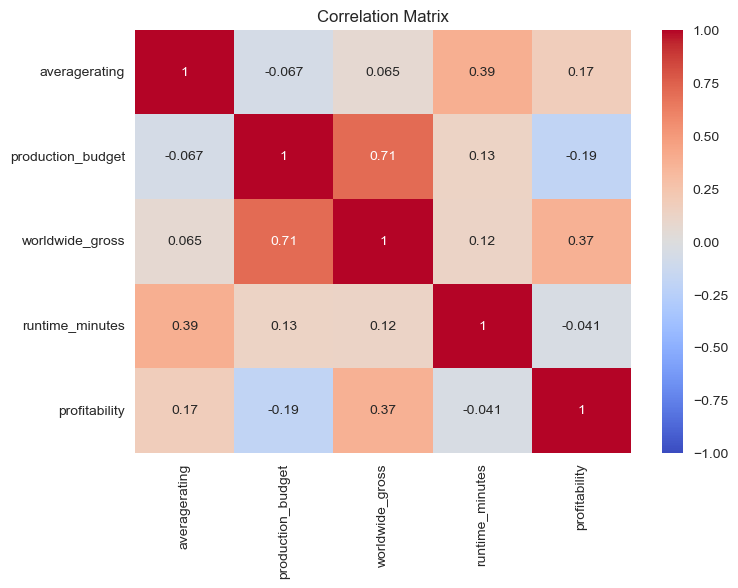

In [1577]:
# Correlation matrix
corr_matrix = df_cleaned[['averagerating', 'production_budget', 'worldwide_gross','runtime_minutes', 'profitability']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows a strong positive relationship between `production budget` and `worldwide gross` (0.71), while profitability is moderately positively correlated with worldwide gross and average rating, and there are weak to no correlations between the remaining variables.

### Regression 
#### Is the correlation between the `produaction_budget` and `worldwide_gross` statistically significant?

In [1578]:
# Regress 'production_budget' against 'worldwide_gross'

# Prepare data for regression
X = df_cleaned['production_budget'].values  # Independent variable
y = df_cleaned['worldwide_gross'].values    # Dependent variable

# Perform linear regression using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Calculate R-squared from r_value
r_squared = r_value**2

# Output the results
print(f'R-squared: {r_squared}')
print(f'Coefficient (Slope): {slope}, Intercept: {intercept}')

R-squared: 0.5002744265512852
Coefficient (Slope): 1.9224699982093725, Intercept: 17362779.133327633


- R-squared of 0.50, indicates that `production_budget` explains 50% of the variance in `worldwide_gross`, with a coefficient (slope) of 1.85 and an intercept of 19,705,776

### Hypothesis Testing
#### Test if movie runtimes affect Production budget using a t-test.

In [1579]:
#Hypothesis  Testing: Test if movie runtimes affect Worldwide gross using a t-test.
# Split data by median runtime
median_runtime = df_cleaned['runtime_minutes'].median()
group1 = df_cleaned[df_cleaned['runtime_minutes'] <= median_runtime]['worldwide_gross']
group2 = df_cleaned[df_cleaned['runtime_minutes'] > median_runtime]['worldwide_gross']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)
print(f'T-test Statistic: {t_stat}, P-value: {p_val}')

T-test Statistic: -1.584298960639201, P-value: 0.11347817182130829


In [1580]:
#Hypothesis  Testing: Test if Averagerating affect Worldwide gross using a t-test.
# Split data by median runtime
median_runtime = df_cleaned['averagerating'].median()
group1 = df_cleaned[df_cleaned['averagerating'] <= median_runtime]['worldwide_gross']
group2 = df_cleaned[df_cleaned['averagerating'] > median_runtime]['worldwide_gross']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)
print(f'T-test Statistic: {t_stat}, P-value: {p_val}')

T-test Statistic: -1.4725875106164208, P-value: 0.1412130742560257


In [1581]:
#Hypothesis  Testing: Test if Production Budget affect Worldwide gross using a t-test.
# Split data by median runtime
median_runtime = df_cleaned['production_budget'].median()
group1 = df_cleaned[df_cleaned['production_budget'] <= median_runtime]['worldwide_gross']
group2 = df_cleaned[df_cleaned['production_budget'] > median_runtime]['worldwide_gross']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)
print(f'T-test Statistic: {t_stat}, P-value: {p_val}')

T-test Statistic: -21.00079089544458, P-value: 5.9217715870443156e-80


In [1582]:
#Hypothesis  Testing: Test if Profitability affect Worldwide gross using a t-test.
# Split data by median runtime
median_runtime = df_cleaned['profitability'].median()
group1 = df_cleaned[df_cleaned['profitability'] <= median_runtime]['worldwide_gross']
group2 = df_cleaned[df_cleaned['profitability'] > median_runtime]['worldwide_gross']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)
print(f'T-test Statistic: {t_stat}, P-value: {p_val}')

T-test Statistic: -14.314396380571242, P-value: 5.1871585026526255e-42


#### - There is a strong correlation between a movie's financial success (worldwide gross) and both its production budget and profitability, while runtime and average rating show no significant impact.

# CONCLUSION
#### - The analysis indicates that movie profitability is influenced by several factors, including genre, release timing, and production budget. Genres such as Music and Horror stand out as particularly profitable, even though they often have lower budgets compared to other genres. Additionally, releasing films during certain months—specifically January, July, and November—tends to maximize box office returns, likely due to favorable seasonal demand. While higher production budgets are correlated with

# RECOMENDATIONS

#### 1. Prioritize Genre Selection for Profitability: Focus on Music and Horror genres, which show high profitability potential. These genres often resonate with niche audiences and can achieve strong box office performance without the need for excessive production budgets. This approach allows the studio to tap into reliable revenue streams while managing costs effectively.

#### 2. Implement Seasonal Release Strategy: Schedule film releases during January, July, and November to optimize profitability by aligning with periods of higher consumer interest and lower competition in the box office. Tailoring release schedules to these strategic windows can help new releases capture a larger share of audience attention and boost revenue potential.

#### 3. Allocate Production Budgets Based on Expected ROI: While higher budgets can drive worldwide gross, focus on optimizing budget according to each film’s potential return on investment (ROI), particularly for high-grossing genres. Avoid excessive spending on films where high budgets may not significantly enhance profitability. Instead, prioritize efficient budget use by carefully assessing the target audience, expected revenue, and genre-specific spending norms.

#### 4. Explore Marketing and Audience Engagement Strategies for High-Return Genres: Since profitability varies widely, strengthen marketing strategies tailored to Music and Horror audiences. By effectively engaging fans through targeted advertising and promotional campaigns, the studio can maximize the visibility and appeal of these genres, enhancing box office performance and profitability.

#### 5. Consider Audience Preference Metrics Over Runtime or Rating Increases: Given the weak correlation between runtime and user ratings, focus less on extending runtime for the sake of ratings and more on delivering quality content that aligns with audience preferences. This strategy can prevent unnecessary production costs tied to longer runtimes and instead channel resources into other value-adding areas, such as special effects or casting that enhance the movie's appeal.